## Installations

In [ ]:
# pip install transformers torchvision matplotlib

## Imports

In [1]:
import torch
from transformers import DetrImageProcessor, DetrForObjectDetection
from PIL import Image
import requests
import matplotlib.pyplot as plt
import matplotlib.patches as patches

## Load pre-trained DETR model and processor

In [2]:
processor = DetrImageProcessor.from_pretrained("facebook/detr-resnet-50")
model = DetrForObjectDetection.from_pretrained("facebook/detr-resnet-50")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/290 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/4.59k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/167M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/102M [00:00<?, ?B/s]

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:2397: UserWarning: for conv1.weight: copying from a non-meta parameter in the checkpoint to a meta parameter in the current model, which is a no-op. (Did you mean to pass `assign=True` to assign items in the state dictionary to their corresponding key in the module instead of copying them in place?)
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:2397: UserWarning: for bn1.weight: copying from a non-meta parameter in the checkpoint to a meta parameter in the current model, which is a no-op. (Did you mean to pass `assign=True` to assign items in the state dictionary to their corresponding key in the module instead of copying them in place?)
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:2397: UserWarning: for bn1.bias: copying from a non-meta parameter in the checkpoint to a meta parameter in the current model, which is a no-op. (Did you mean to pas

## Inference

In [9]:
# Load an image
url = "https://media.istockphoto.com/id/1497909628/photo/cat-and-dog-sitting-together-on-meadow.jpg?s=612x612&w=0&k=20&c=zpZE3_h5u8pnkml1qPyX31KXuIodY8KQ1bwkH7BWc_Q="
image = Image.open(requests.get(url, stream=True).raw)
# image = Image.open("Site_1_Camera_2575________Windsor_Manor_FIX_1________WINDSOR_MANOR_JUNCTION_1RitX5J_2.jpg")

# Preprocess
inputs = processor(images=image, return_tensors="pt")

# Inference
with torch.no_grad():
    outputs = model(**inputs)

# Get logits and boxes
logits = outputs.logits
boxes = outputs.pred_boxes

# Apply softmax to get class probabilities
probs = logits.softmax(-1)[0, :, :-1]  # Remove "no-object" class
scores, labels = probs.max(-1)

# Thresholding detections
threshold = 0.9
keep = scores > threshold

## Visualization

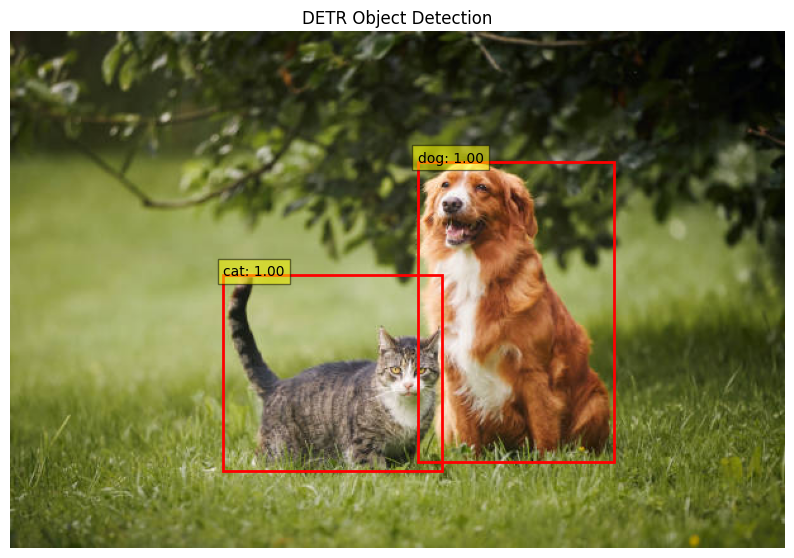

In [10]:
plt.figure(figsize=(10, 8))
plt.imshow(image)
ax = plt.gca()

for score, label, box in zip(scores[keep], labels[keep], boxes[0][keep]):
    label_name = model.config.id2label[label.item()]

    box = box.cpu() * torch.tensor([image.width, image.height, image.width, image.height])
    x_center, y_center, width, height = box
    x = x_center - width / 2
    y = y_center - height / 2

    rect = patches.Rectangle((x, y), width, height, linewidth=2, edgecolor='red', facecolor='none')
    ax.add_patch(rect)
    ax.text(x, y, f"{label_name}: {score:.2f}", bbox=dict(facecolor='yellow', alpha=0.5))

plt.axis('off')
plt.title("DETR Object Detection")
plt.show()